Hyperparameter tuning

In [2]:
from CBF.cbf_recommender import cbf_recommender
from utils.evaluator.evaluator import evaluator
from utils.submission_helper import submission_helper
from utils.data_manager.data_manager import data_manager
from utils.data_manager.splitter import splitter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Now I'm trying to discover the best similarity heuristic and also if there is a dependency on the k parameter

In [3]:
training, validation, test = splitter().get_train_evaluation_test(percentage_of_training_data=0.6,
                                                                  percentage_of_validation_data=0.2)

In [3]:
k = [100, 250, 400]
similarities = ['pearson', 'cosine', 'adjusted', 'asymmetric', 'jaccard', 'tanimoto',
                             'dice', 'tversky']
map_vectors = []
for chosen_k in k:
    map_vector = []
    for chosen_similarity in similarities:
        recommender_ = cbf_recommender()
        recommender_.fit(training, k=chosen_k, normalize=True, similarity=chosen_similarity)
        map_vector.append(evaluator.evaluate_already_trained(recommender=recommender_)[2])
    map_vectors.append(map_vector)
index = 0
for vector in map_vectors:
    print("k: ", k[index], "map: ", vector, "similarities: ", similarities)
    index+=1

Similarity column 25975 ( 100 % ), 1786.00 column/sec, elapsed time 0.24 min
Similarity column 25975 ( 100 % ), 1750.37 column/sec, elapsed time 0.25 min
Similarity column 25975 ( 100 % ), 1878.82 column/sec, elapsed time 0.23 min
Similarity column 25975 ( 100 % ), 1278.19 column/sec, elapsed time 0.34 min
Similarity column 25975 ( 100 % ), 1345.32 column/sec, elapsed time 0.32 min
Similarity column 25975 ( 100 % ), 1155.31 column/sec, elapsed time 0.37 min
Similarity column 25975 ( 100 % ), 1530.08 column/sec, elapsed time 0.28 min
Similarity column 25975 ( 100 % ), 982.48 column/sec, elapsed time 0.44 min
Similarity column 25975 ( 100 % ), 1351.02 column/sec, elapsed time 0.32 min
Similarity column 25975 ( 100 % ), 1395.25 column/sec, elapsed time 0.31 min
Similarity column 25975 ( 100 % ), 1251.66 column/sec, elapsed time 0.35 min
Similarity column 25975 ( 100 % ), 1431.29 column/sec, elapsed time 0.30 min
Similarity column 25975 ( 100 % ), 1094.68 column/sec, elapsed time 0.40 min


Similarity column 25975 ( 100 % ), 1399.97 column/sec, elapsed time 0.31 min
Similarity column 25975 ( 100 % ), 1334.52 column/sec, elapsed time 0.32 min
Similarity column 25975 ( 100 % ), 1225.60 column/sec, elapsed time 0.35 min
Similarity column 25975 ( 100 % ), 1141.72 column/sec, elapsed time 0.38 min
Similarity column 25975 ( 100 % ), 1112.47 column/sec, elapsed time 0.39 min
Similarity column 25975 ( 100 % ), 992.88 column/sec, elapsed time 0.44 min
Similarity column 25975 ( 100 % ), 1286.34 column/sec, elapsed time 0.34 min
Similarity column 25975 ( 100 % ), 1100.29 column/sec, elapsed time 0.39 min
Similarity column 25975 ( 100 % ), 1184.67 column/sec, elapsed time 0.37 min
Similarity column 25975 ( 100 % ), 1034.44 column/sec, elapsed time 0.42 min
Similarity column 25975 ( 100 % ), 1238.58 column/sec, elapsed time 0.35 min
Similarity column 25975 ( 100 % ), 980.42 column/sec, elapsed time 0.44 min
Similarity column 25975 ( 100 % ), 956.37 column/sec, elapsed time 0.45 min
Si

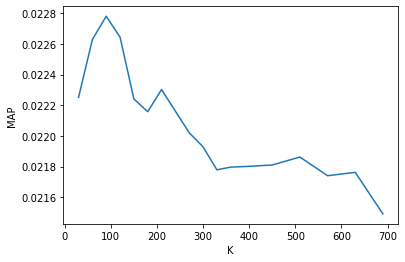

In [4]:
k_tested = [i for i in range(30,400,30)]
k1 = [i for i in range(450, 700, 60)]
k_tested = k_tested + k1
map_=[]
for k in k_tested:
    recommender_k = cbf_recommender()
    recommender_k.fit(training, k=k, normalize=True, similarity='jaccard')
    map_.append(evaluator.evaluate_already_trained(recommender=recommender_k)[2])
plt.plot(k_tested, map_)
plt.ylabel('MAP')
plt.xlabel('K')
plt.show()

In [5]:
k = k_tested[np.argmax(map_)]
k

90

Similarity column 25975 ( 100 % ), 866.91 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 914.98 column/sec, elapsed time 0.47 min
Similarity column 25975 ( 100 % ), 904.72 column/sec, elapsed time 0.48 min
Similarity column 25975 ( 100 % ), 895.35 column/sec, elapsed time 0.48 min
Similarity column 25900 ( 100 % ), 862.42 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 862.42 column/sec, elapsed time 0.50 min
Similarity column 24300 ( 94 % ), 808.11 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 780.11 column/sec, elapsed time 0.55 min
Similarity column 20100 ( 77 % ), 669.41 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 692.27 column/sec, elapsed time 0.63 min
Similarity column 20500 ( 79 % ), 680.19 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 665.93 column/sec, elapsed time 0.65 min
Similarity column 18100 ( 70 % ), 602.71 column/sec, elapsed time 0.50 min
Similarity colum

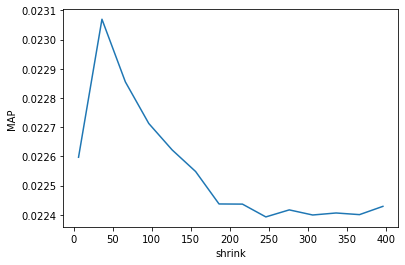

In [6]:
shrinks = [i for i in range(6,400, 30)]
map_=[]
for s in shrinks:
    recommender_shrink = cbf_recommender()
    recommender_shrink.fit(training, k=90, shrink=s, normalize=True, similarity='jaccard')
    map_.append(evaluator.evaluate_already_trained(recommender=recommender_shrink)[2])
plt.plot(shrinks, map_)
plt.ylabel('MAP')
plt.xlabel('shrink')
plt.show()

In [7]:
shrink = shrinks[np.argmax(map_)]
shrink


36

Similarity column 23700 ( 91 % ), 789.06 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 789.83 column/sec, elapsed time 0.55 min
Similarity column 18100 ( 70 % ), 601.95 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 586.57 column/sec, elapsed time 0.74 min
Similarity column 23400 ( 90 % ), 779.23 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 778.64 column/sec, elapsed time 0.56 min
Similarity column 21900 ( 84 % ), 728.83 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 728.56 column/sec, elapsed time 0.59 min
Similarity column 22900 ( 88 % ), 761.62 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 750.73 column/sec, elapsed time 0.58 min
Similarity column 21600 ( 83 % ), 716.76 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 728.31 column/sec, elapsed time 0.59 min
Similarity column 21800 ( 84 % ), 726.42 column/sec, elapsed time 0.50 min
Similarity column 2

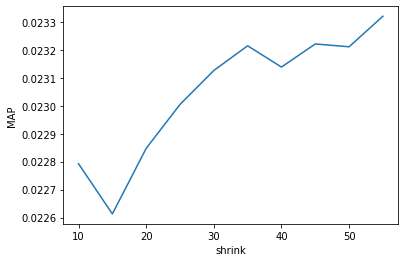

In [8]:
shrinks = [i for i in range(10,60, 5)]
map_=[]
for s in shrinks:
    recommender_s = cbf_recommender()
    recommender_s.fit(training, k=90, shrink=s, normalize=True, similarity='jaccard')
    map_.append(evaluator.evaluate_already_trained(recommender=recommender_s)[2])
plt.plot(shrinks, map_)
plt.ylabel('MAP')
plt.xlabel('shrink')
plt.show()

In [9]:
shrink = shrinks[np.argmax(map_)]
shrink

55

In [10]:
from utils.IR_feature_weighting import okapi_BM_25
ICM_BM25 = data_manager().get_icm().astype(np.float32)
ICM_BM25 = okapi_BM_25(ICM_BM25)
ICM_BM25 = ICM_BM25.tocsc()
recommender_BM = cbf_recommender(icm=ICM_BM25)
recommender_BM.fit(training_set=training, shrink=60, k=90, similarity='jaccard')
map_ = evaluator.evaluate_already_trained(recommender=recommender_BM)[2]
print(map_)

Similarity column 23200 ( 89 % ), 770.38 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 767.66 column/sec, elapsed time 0.56 min
0.023148312571047568


In [11]:
from utils.IR_feature_weighting import TF_IDF
import scipy.sparse as sparse
icm = data_manager().get_icm()
num_tot_items = icm.shape[0]
items_per_feature = (icm>0).sum(axis=0)
IDF = np.array(np.log(num_tot_items/items_per_feature))[0]
icm_idf = icm.copy()
col_nnz = np.diff(sparse.csc_matrix(icm_idf).indptr)
icm_idf.data *= np.repeat(IDF, col_nnz)
recommender_idf = cbf_recommender(icm=icm_idf)
recommender_idf.fit(training_set=training, shrink=60, k =90, similarity='jaccard')
map_ = evaluator.evaluate_already_trained(recommender=recommender_idf)[2]
print(map_)


C:\Users\Luca Massini\anaconda3\envs\recsys-challenge-Polimi-2020\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Similarity column 22900 ( 88 % ), 762.49 column/sec, elapsed time 0.50 min
Similarity column 25975 ( 100 % ), 764.47 column/sec, elapsed time 0.57 min
0.023148312571047568


In [4]:
similarity_vector = ['asymmetric', 'jaccard', 'tanimoto', 'dice', 'tversky']
map_rec = []
for similarity in similarity_vector:
    recommender_test = cbf_recommender()
    recommender_test.fit(training_set=training, shrink=55, k=90, similarity=similarity)
    map_rec.append(evaluator.evaluate_already_trained(recommender=recommender_test)[2])
print("map: ",map_rec, "similarity :", similarity_vector)

Similarity column 25975 ( 100 % ), 1679.89 column/sec, elapsed time 0.26 min
Similarity column 25975 ( 100 % ), 1538.86 column/sec, elapsed time 0.28 min
Similarity column 25975 ( 100 % ), 1509.41 column/sec, elapsed time 0.29 min
Similarity column 25975 ( 100 % ), 1688.11 column/sec, elapsed time 0.26 min
Similarity column 25975 ( 100 % ), 1205.11 column/sec, elapsed time 0.36 min
map:  [0.014688755860382444, 0.023319707839602855, 0.023319707839602855, 0.02329373422341659, 0.023319707839602855] similarity : ['asymmetric', 'jaccard', 'tanimoto', 'dice', 'tversky']


In [8]:
recommender_submission = cbf_recommender()
recommender_submission.fit(training_set=data_manager().get_urm(),
                           shrink=55,
                           k=90,
                           similarity='dice')
s=submission_helper(name_of_the_file='dice',
                  recommender=recommender_submission)
s.build_submission()

Similarity column 25975 ( 100 % ), 1474.04 column/sec, elapsed time 0.29 min
